# Multi-Layer Perceptron From Scratch with Numpy

The MIT License (MIT)

Copyright (c) 2016 Koki Saitoh

Edited by Hancheol Moon
- Input-Hidden-Output
- Sigmoid activation
- SGD
- Cross-Entropy

## Create Dataset
- X: 300 x 2
- Y: 3

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def load_data(seed=1984):
    np.random.seed(seed)
    N = 100
    DIM = 2
    CLS_NUM = 3
    
    x = np.zeros((N*CLS_NUM, DIM))
    t = np.zeros((N*CLS_NUM, CLS_NUM), dtype=np.int)
    
    for j in range(CLS_NUM):
        for i in range(N): # N*j, N*(j+1)):
            rate = i / N
            radius = 1.0 * rate
            theta = j*4.0 + 4.0*rate + np.random.randn()*0.2
            
            ix = N*j + i
            x[ix] = np.array([radius*np.sin(theta),
                             radius*np.cos(theta)]).flatten()
            
            t[ix, j] = 1
            
    return x, t

x: (300, 2)
t: (300, 3)


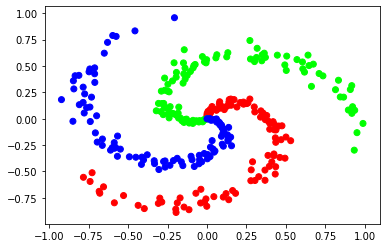

In [4]:
x, t = load_data()
print(f'x: {x.shape}')
print(f't: {t.shape}')

plt.scatter(x[:,0], x[:,1], color=t)
plt.show()

## Optimizer

In [5]:
class SGD():
    """ Stochastic Gradient Descent """
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for i in range(len(params)):
            params[i] -= self.lr * grads[i]
            
def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)
    
    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate

## Model Class
- Define model class
- Activation functions
- Softmax
- Cross-Entropy

In [6]:
class TwoLayerNet():
    def __init__(self, input_size, hidden_size, output_size): 

        I, H, O = input_size, hidden_size, output_size
        
        # Define Network Paramers
        W1 = np.random.randn(I, H)*0.01 # (InputFeature x HiddenNodes): 2x10
        b1 = np.zeros(H)

        W2 = np.random.randn(H, O)*0.01 # (HiddenNodes x OutputDim): 10x3
        b2 = np.zeros(O)
        
        # Build Network Layers
        # Two hidden layers
        self.layers = [
            Affine(W1, b1), # Hidden layer
            Sigmoid(),
            Affine(W2, b2), # Output layer (FC Layer in DL)
            ]

        
        # Softmax with Loss
        self.loss_layer = SoftmaxWithLoss()
        
        self.params = []
        self.grads = []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
        
    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def forward(self, x, t):
        score = self.predict(x)
        loss = self.loss_layer.forward(score, t)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for i, layer in enumerate(reversed(self.layers)): # Reverse Order: Affine2, Sigmoid, Affine1
            dout = layer.backward(dout)
        return dout

class Affine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        W, b = self.params
        out = np.dot(x, W) + b
        self.x = x
        return out

    def backward(self, dout):
        #pdb.set_trace() 
        W, b = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        db = np.sum(dout, axis=0)

        self.grads[0][...] = dW
        self.grads[1][...] = db
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmax output
        self.t = None  # target label

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        # If the target is one-hot then change into idx
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_loss(self.y, self.t)
        return loss, self.y

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx

def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x) # For numerical stability
        x = np.exp(x) / np.sum(np.exp(x))

    return x


def cross_entropy_loss(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # One-hot 2 Index
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

class Sigmoid:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx

class ReLU:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

## Train Model

In [7]:
import time
import matplotlib.pyplot as plt

if __name__ == "__main__":
    # Load data
    x, t = load_data()
    
    # Define Hyperparameter
    max_epoch = 200
    batch_size = 30
    hidden_size = 10
    learning_rate = 1.0
    
    data_size = len(x)
    max_iters = data_size // batch_size
    total_loss = 0
    loss_count = 0
    loss_list = []
    
    # Load Model / Load Optimizer
    model = TwoLayerNet(input_size=2, hidden_size=hidden_size, output_size=3)
    optimizer = SGD(lr=learning_rate)
    
    # Start Training
    for epoch in range(max_epoch):
        
        # Shuffle data
        idx = np.random.permutation(data_size)
        x = x[idx]
        t = t[idx]
        
        for iters in range(max_iters):
            start_t = time.perf_counter()
            batch_x = x[iters*batch_size:(iters+1)*batch_size]
            batch_t = t[iters*batch_size:(iters+1)*batch_size]
            
            loss, pred_ = model.forward(batch_x, batch_t)
            model.backward()
            optimizer.update(model.params, model.grads)
            
            total_loss += loss
            loss_count += 1
            
            ent_t = time.perf_counter()
            iter_time = ent_t - start_t
            
            if(iters+1) % 10 == 0:
                avg_loss = total_loss / loss_count
                pred = np.argmax(pred_, axis=1)
                acc = np.sum(pred==batch_t.argmax(axis=1))/batch_size
                
                print(f'Epoch: {epoch} || Iter: {iters}/{max_iters} || Accuracy: {acc:.2f} || AverageLoss: {avg_loss:.4f} || Elapsed: {iter_time:.6f}')
                loss_list.append(avg_loss)
                total_loss, loss_count = 0, 0

Epoch: 0 || Iter: 9/10 || Accuracy: 0.27 || AverageLoss: 1.1256 || Elapsed: 0.000959
Epoch: 1 || Iter: 9/10 || Accuracy: 0.33 || AverageLoss: 1.1255 || Elapsed: 0.000489
Epoch: 2 || Iter: 9/10 || Accuracy: 0.30 || AverageLoss: 1.1163 || Elapsed: 0.000605
Epoch: 3 || Iter: 9/10 || Accuracy: 0.50 || AverageLoss: 1.1163 || Elapsed: 0.000984
Epoch: 4 || Iter: 9/10 || Accuracy: 0.43 || AverageLoss: 1.1123 || Elapsed: 0.000892
Epoch: 5 || Iter: 9/10 || Accuracy: 0.17 || AverageLoss: 1.1385 || Elapsed: 0.000928
Epoch: 6 || Iter: 9/10 || Accuracy: 0.40 || AverageLoss: 1.1591 || Elapsed: 0.000477
Epoch: 7 || Iter: 9/10 || Accuracy: 0.37 || AverageLoss: 1.1086 || Elapsed: 0.000546
Epoch: 8 || Iter: 9/10 || Accuracy: 0.23 || AverageLoss: 1.1173 || Elapsed: 0.000509
Epoch: 9 || Iter: 9/10 || Accuracy: 0.30 || AverageLoss: 1.1288 || Elapsed: 0.000477
Epoch: 10 || Iter: 9/10 || Accuracy: 0.20 || AverageLoss: 1.1168 || Elapsed: 0.000379
Epoch: 11 || Iter: 9/10 || Accuracy: 0.47 || AverageLoss: 1.1083

Epoch: 154 || Iter: 9/10 || Accuracy: 0.97 || AverageLoss: 0.2151 || Elapsed: 0.000259
Epoch: 155 || Iter: 9/10 || Accuracy: 0.90 || AverageLoss: 0.2084 || Elapsed: 0.000191
Epoch: 156 || Iter: 9/10 || Accuracy: 0.83 || AverageLoss: 0.2091 || Elapsed: 0.000142
Epoch: 157 || Iter: 9/10 || Accuracy: 0.93 || AverageLoss: 0.2048 || Elapsed: 0.000139
Epoch: 158 || Iter: 9/10 || Accuracy: 0.90 || AverageLoss: 0.2086 || Elapsed: 0.000173
Epoch: 159 || Iter: 9/10 || Accuracy: 0.97 || AverageLoss: 0.1982 || Elapsed: 0.000142
Epoch: 160 || Iter: 9/10 || Accuracy: 0.83 || AverageLoss: 0.2044 || Elapsed: 0.000165
Epoch: 161 || Iter: 9/10 || Accuracy: 0.97 || AverageLoss: 0.1972 || Elapsed: 0.000149
Epoch: 162 || Iter: 9/10 || Accuracy: 0.93 || AverageLoss: 0.2120 || Elapsed: 0.000303
Epoch: 163 || Iter: 9/10 || Accuracy: 0.93 || AverageLoss: 0.1999 || Elapsed: 0.000235
Epoch: 164 || Iter: 9/10 || Accuracy: 0.97 || AverageLoss: 0.1967 || Elapsed: 0.000140
Epoch: 165 || Iter: 9/10 || Accuracy: 0.97 

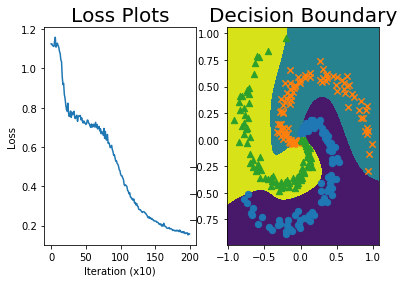

In [13]:
# Plot Loss
fig, axes = plt.subplots(1, 2)
axes[0].plot(np.arange(len(loss_list)), loss_list, label='train')
axes[0].set_title('Loss Plots', fontsize=20)
axes[0].set_xlabel('Iteration (x10)')
axes[0].set_ylabel('Loss')

# Decision Boundary
h = 0.001
x_min, x_max = x[:, 0].min() - .1, x[:, 0].max() + .1
y_min, y_max = x[:, 1].min() - .1, x[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
X = np.c_[xx.ravel(), yy.ravel()]
score = model.predict(X)
predict_cls = np.argmax(score, axis=1)
Z = predict_cls.reshape(xx.shape)
axes[1].set_title('Decision Boundary', fontsize=20)
axes[1].contourf(xx, yy, Z)

# Decision Boundary
x, t = load_data()
N = 100
CLS_NUM = 3
markers = ['o', 'x', '^']
for i in range(CLS_NUM):
    axes[1].scatter(x[i*N : (i+1)*N, 0], x[i*N : (i+1)*N, 1], s=40, marker=markers[i])
plt.show()

In [18]:
print(xx.shape)
print(xx)
print(yy.shape)
print(yy)
print(Z.shape)
print(Z)

(2047, 2112)
[[-1.0223507 -1.0213507 -1.0203507 ...  1.0866493  1.0876493  1.0886493]
 [-1.0223507 -1.0213507 -1.0203507 ...  1.0866493  1.0876493  1.0886493]
 [-1.0223507 -1.0213507 -1.0203507 ...  1.0866493  1.0876493  1.0886493]
 ...
 [-1.0223507 -1.0213507 -1.0203507 ...  1.0866493  1.0876493  1.0886493]
 [-1.0223507 -1.0213507 -1.0203507 ...  1.0866493  1.0876493  1.0886493]
 [-1.0223507 -1.0213507 -1.0203507 ...  1.0866493  1.0876493  1.0886493]]
(2047, 2112)
[[-0.98867266 -0.98867266 -0.98867266 ... -0.98867266 -0.98867266
  -0.98867266]
 [-0.98767266 -0.98767266 -0.98767266 ... -0.98767266 -0.98767266
  -0.98767266]
 [-0.98667266 -0.98667266 -0.98667266 ... -0.98667266 -0.98667266
  -0.98667266]
 ...
 [ 1.05532734  1.05532734  1.05532734 ...  1.05532734  1.05532734
   1.05532734]
 [ 1.05632734  1.05632734  1.05632734 ...  1.05632734  1.05632734
   1.05632734]
 [ 1.05732734  1.05732734  1.05732734 ...  1.05732734  1.05732734
   1.05732734]]
(2047, 2112)
[[0 0 0 ... 0 0 0]
 [0 0 

In [22]:
predict_cls.shape

(4323264,)

In [19]:
help(axes[1].contourf)

Help on method contourf in module matplotlib.axes._axes:

contourf(*args, data=None, **kwargs) method of matplotlib.axes._subplots.AxesSubplot instance
    Plot contours.
    
    Call signature::
    
        contour([X, Y,] Z, [levels], **kwargs)
    
    `.contour` and `.contourf` draw contour lines and filled contours,
    respectively.  Except as noted, function signatures and return values
    are the same for both versions.
    
    Parameters
    ----------
    X, Y : array-like, optional
        The coordinates of the values in *Z*.
    
        *X* and *Y* must both be 2-D with the same shape as *Z* (e.g.
        created via `numpy.meshgrid`), or they must both be 1-D such
        that ``len(X) == M`` is the number of columns in *Z* and
        ``len(Y) == N`` is the number of rows in *Z*.
    
        If not given, they are assumed to be integer indices, i.e.
        ``X = range(M)``, ``Y = range(N)``.
    
    Z : array-like(N, M)
        The height values over which the co